In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy import stats
import gseapy as gp
from gseapy import barplot, dotplot
import seaborn as sns
import matplotlib.pyplot as plt
import PyComplexHeatmap as pch
from PyComplexHeatmap import *

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
def filter_terms(terms):
    term_dict = {}
    for term in terms:
        first_word = term.split()[0]
        if first_word not in term_dict:
            term_dict[first_word] = term
    return list(term_dict.values())


## GO

In [3]:
_gender = 'Male'
mc_type = 'CGN'
ct_type = 'All_CellType'

In [4]:
gene_name_to_id = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [5]:
_dir = '/home/qzeng/project/aging/240112_DMG_CEF'
mc_all = pd.read_csv(f'{_dir}/result/{_gender}.{mc_type}.DMG.csv', index_col = 0)
mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
use_cts= joblib.load('mc_rna_corr_cts')
if ct_type == 'Neuron':
    use_cts = [ct for ct in use_cts if ct.endswith('NN') == False]
elif ct_type == 'NN':
    use_cts = [ct for ct in use_cts if ct.endswith('NN') == True]
if ct_type == 'All_CellType':
    use_cts= joblib.load('mc_rna_corr_cts')

In [7]:
_type = 'DEG'
pvalue_cutoff = 0.05
fc_cutoff = 0.1

In [16]:
all_up_genes = []
all_down_genes = []
all_deg_df = []

for ct in use_cts:
    rna_df = pd.read_csv(f"DEGs/{ct}.csv", index_col = 0)
    rna_df['log2(Aged/Young)'] = -rna_df['avg_log2FC']
    deg_df = rna_df[(rna_df['p_val_adj'] < pvalue_cutoff) & (abs(rna_df['log2(Aged/Young)']) > fc_cutoff)]
    
    up_genes = deg_df[deg_df['log2(Aged/Young)'] > 0].index
    down_genes = deg_df[deg_df['log2(Aged/Young)'] < 0].index
    
    # get DEG mc info
    mc_df  = mc_all[mc_all['celltype'] == ct].copy()
    mc_df['gene_name'] = mc_df.index.map(gene_id_to_name)

    deg_mc_df = mc_df.set_index('gene_name')
    deg_mc_df = deg_mc_df.loc[deg_mc_df.index.isin(deg_df.index)]
    deg_mc_df['Aged-Young'] = deg_mc_df['18mo'] - deg_mc_df['8wk']
    
    
    # also filter for DMGs
    deg_mc_df  = deg_mc_df[deg_mc_df['pvalue'] < 0.05]
    mc_hyper_genes = deg_mc_df[deg_mc_df['Aged-Young'] > 0].index
    mc_hypo_genes = deg_mc_df[deg_mc_df['Aged-Young'] < 0].index
    all_deg_df.append(deg_mc_df)
    
    # unique_genes = deg_mc_df.index.value_counts()[deg_mc_df.index.value_counts() == 1].index
    up_genes = list(set(mc_hypo_genes) & set(up_genes))
    down_genes = list(set(mc_hyper_genes) & set(down_genes))
    all_up_genes += list(up_genes)
    all_down_genes += list(down_genes)


In [9]:
#mouse = gp.get_library_name(organism='mouse')

In [10]:
all_genes = list(set(all_up_genes + all_down_genes))
all_up_genes = list(set(all_up_genes))
all_down_genes = list(set(all_down_genes))
len(all_genes), len(all_up_genes) , len(all_down_genes)                      

(5128, 1569, 3991)

In [14]:
'Suv39h2' in all_down_genes

True

In [61]:
gene_sets = [
              'KEGG_2019_Mouse',
              'GO_Biological_Process_2023', 
              'GO_Molecular_Function_2023',
              'WikiPathways_2019_Mouse',
              'Reactome_2022'
               ]

In [62]:
go_enrichment = gp.enrichr(gene_list=all_down_genes,
                           gene_sets=gene_sets,
                           organism='mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.01) # set a significance cutoff
result_df= go_enrichment.results.copy()
result_df.to_csv(f'GO_analysis/{ct_type}.Down.enrichr.result.csv')

In [63]:
go_enrichment = gp.enrichr(gene_list=all_up_genes,
                           gene_sets=gene_sets,
                           organism='mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.01) # set a significance cutoff
result_df= go_enrichment.results.copy()
result_df.to_csv(f'GO_analysis/{ct_type}.Up.enrichr.result.csv')

In [64]:
go_enrichment = gp.enrichr(gene_list=all_genes,
                           gene_sets=gene_sets,
                           organism='mouse', # don't forget to set organism
                           #outdir='test/go', # set the output directory
                           no_plot=False, # do not draw a plot
                           cutoff=0.01) # set a significance cutoff
result_df= go_enrichment.results.copy()
result_df.to_csv(f'GO_analysis/{ct_type}.All.enrichr.result.csv')

## plot

In [3]:
import glob
all_files = glob.glob(f'GO_analysis/*.enrichr.result.csv')
all_files

['GO_analysis/Neuron.Up.enrichr.result.csv',
 'GO_analysis/Neuron.All.enrichr.result.csv',
 'GO_analysis/Neuron.Down.enrichr.result.csv',
 'GO_analysis/NN.Down.enrichr.result.csv',
 'GO_analysis/NN.Up.enrichr.result.csv',
 'GO_analysis/NN.All.enrichr.result.csv',
 'GO_analysis/All_CellType.Down.enrichr.result.csv',
 'GO_analysis/All_CellType.Up.enrichr.result.csv',
 'GO_analysis/All_CellType.All.enrichr.result.csv']

In [6]:
fp = 'GO_analysis/All_CellType.Down.enrichr.result.csv'
group = fp.split('/')[-1].split('.enrichr')[0]
group

'All_CellType.Down'

In [69]:
result_df = pd.read_csv(fp, index_col =0)
result_df['gene_num'] = result_df['Overlap'].apply(lambda x: int(x.split('/')[-1]))
result_df = result_df[(result_df['Adjusted P-value']  < 1e-3) & (result_df['gene_num']  > 5)]
result_df.sort_values('Adjusted P-value').head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,gene_num
5065,GO_Molecular_Function_2023,RNA Binding (GO:0003723),509/1411,8.971776e-49,8.774397e-46,0,0,2.448278,270.859312,RPL4;POP5;RPL5;RAMAC;RPL30;POP7;RPL3;TFRC;RPL3...,1411
296,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),83/93,3.752725e-47,1.789675e-43,0,0,33.979452,3632.370064,EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31...,93
6202,Reactome_2022,Eukaryotic Translation Elongation R-HSA-156842,80/90,3.513300e-45,5.782891e-42,0,0,32.726157,3349.842016,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...,90
6203,Reactome_2022,Eukaryotic Translation Termination R-HSA-72764,79/90,1.049024e-43,7.946447e-41,0,0,29.369818,2906.534049,N6AMT1;RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;...,90
6204,Reactome_2022,Nonsense Mediated Decay (NMD) Independent Of E...,80/92,1.448320e-43,7.946447e-41,0,0,27.268388,2689.774410,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...,92


In [64]:
#result_df['Gene_set'].value_counts()

In [65]:
gene_sets = [
              'KEGG_2019_Mouse',
              'GO_Biological_Process_2023', 
              'GO_Molecular_Function_2023',
              'WikiPathways_2019_Mouse',
              'Reactome_2022'
               ]

In [70]:
result_df = result_df[result_df['Gene_set'].isin(['GO_Biological_Process_2023', 'GO_Molecular_Function_2023'])]

In [11]:
all_terms = result_df['Term'].unique()
filtered_terms = filter_terms(all_terms)

In [13]:
to_plot = result_df[result_df['Term'].isin(filtered_terms)]
to_plot = to_plot[['Genes','Term']].copy()
to_plot = to_plot.assign(Genes=to_plot.Genes.str.split(';')).explode('Genes').reset_index(drop=True)

In [14]:
heatmap_data = to_plot.pivot_table(index='Genes', columns='Term', aggfunc='size', fill_value=0)
heatmap_data = heatmap_data.T

In [15]:
row_annot = pd.DataFrame(heatmap_data.index, columns=['Term'], index = heatmap_data.index)
row_annot['Term'] = row_annot['Term'].apply(lambda x: x.split('(')[0])
row_annot['Term'] = row_annot['Term'].apply(lambda x: x.split('R-HSA')[0])
row_annot.head()

,Term
Term,
Aerobic Electron Transport Chain (GO:0019646),Aerobic Electron Transport Chain
Autophagosome Assembly (GO:0000045),Autophagosome Assembly
Axon Development (GO:0061564),Axon Development
Axonogenesis (GO:0007409),Axonogenesis
Cadherin Binding (GO:0045296),Cadherin Binding


In [16]:
row_ha = pch.HeatmapAnnotation(label=pch.anno_label(row_annot.Term, merge=True,rotation=0, colors = 'black' ),
                                #Motif=pch.anno_simple(row_annot.Motif,add_text=False,legend=False,height = 6), 
                               axis=0,
                               legend=False,legend_gap=5,hgap=0.5, label_kws=dict(visible=False))

In [17]:
# heatmap_data.index = heatmap_data.index.map(lambda x: x.split('(')[0])
# heatmap_data.index = heatmap_data.index.map(lambda x: x.split('R-HSA')[0])

In [18]:
heatmap_data.shape

(36, 1184)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


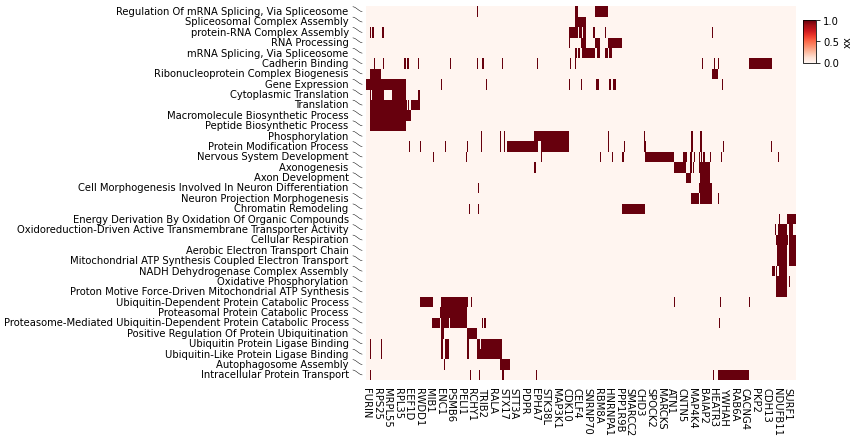

In [19]:
plt.figure(figsize=(8,6))
cm = ClusterMapPlotter(
        data=heatmap_data, 
        #show_rownames=True,
        show_colnames=True,
        left_annotation=row_ha,
        vmin = 0, vmax = 1,
        col_cluster=True,row_cluster=True,
        label = 'xx',z_score = False,
        cmap='Reds',rasterized=True)
#plt.suptitle(f"{group}")
#plt.savefig(f"figure/{group}.result.PycomplexClustertmap.pdf", bbox_inches='tight')
plt.show()

## make barplot

In [74]:
plot_term = ['mRNA Binding (GO:0003729)',
             'Mitochondrial ATP Synthesis Coupled Electron Transport (GO:0042775)',
             'Axonogenesis (GO:0007409)',
             'Cadherin Binding (GO:0045296)',
             'Ubiquitin-Dependent Protein Catabolic Process (GO:0006511)',
             'mRNA Splicing, Via Spliceosome (GO:0000398)',
             'Ribonucleoprotein Complex Biogenesis (GO:0022613)',
             'Chromatin Remodeling (GO:0006338)']

In [75]:
for_bar_plot = result_df[result_df['Term'].isin(plot_term)]
for_bar_plot = for_bar_plot[['Term','Adjusted P-value','Genes']]

In [76]:
result_df.sort_values('Adjusted P-value')[10:20]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,gene_num
5066,GO_Molecular_Function_2023,mRNA Binding (GO:0003729),108/282,6.491684e-13,2.909048e-10,0,0,2.531193,71.033070,EIF4A1;RPL5;FMR1;HDLBP;HNRNPU;RPL7;RPS14;EIF4E...,282
304,GO_Biological_Process_2023,protein-RNA Complex Assembly (GO:0022618),68/150,1.638300e-12,8.681172e-10,0,0,3.366749,91.364684,RPL5;RAMAC;HSP90AB1;CELF1;CELF3;RPLP0;CELF4;CE...,150
305,GO_Biological_Process_2023,Axonogenesis (GO:0007409),79/188,3.525858e-12,1.681482e-09,0,0,2.945770,77.682604,CYFIP2;EPHB6;SEMA5A;ROBO2;SEMA5B;ROBO3;RAB3A;H...,188
306,GO_Biological_Process_2023,Aerobic Respiration (GO:0009060),34/59,2.076199e-10,9.001267e-08,0,0,5.493616,122.481892,NDUFB9;NDUFA13;NDUFB8;NDUFB7;NDUFA11;NDUFB10;N...,59
307,GO_Biological_Process_2023,"Mitochondrial Electron Transport, NADH To Ubiq...",24/34,2.386305e-10,9.483574e-08,0,0,9.679254,214.454562,NDUFB9;NDUFA8;NDUFB8;NDUFA7;NDUFB7;NDUFA6;NDUF...,34
308,GO_Biological_Process_2023,"Regulation Of mRNA Splicing, Via Spliceosome (...",46/94,2.754011e-10,1.010298e-07,0,0,3.877302,85.350255,KHDRBS1;RBM25;DDX5;KHDRBS3;RBM8A;CELF1;YTHDC1;...,94
309,GO_Biological_Process_2023,Protein Modification Process (GO:0036211),210/711,3.497596e-10,1.191431e-07,0,0,1.719217,37.433843,EPHB6;GMFB;MAML1;PPP2R2A;UBE2L3;GOLGA2;PPP2R1A...,711
5068,GO_Molecular_Function_2023,NADH Dehydrogenase (Ubiquinone) Activity (GO:0...,23/33,8.514303e-10,2.081747e-07,0,0,9.273614,193.671112,NDUFB9;NDUFA8;NDUFB8;NDUFA7;NDUFB7;NDUFA6;NDUF...,33
311,GO_Biological_Process_2023,Mitochondrial Respiratory Chain Complex I Asse...,31/53,7.811117e-10,2.328201e-07,0,0,5.688671,119.293150,NDUFB9;NDUFA13;NDUFB8;NDUFB7;NDUFA11;NDUFB10;N...,53
310,GO_Biological_Process_2023,NADH Dehydrogenase Complex Assembly (GO:0010257),31/53,7.811117e-10,2.328201e-07,0,0,5.688671,119.293150,NDUFB9;NDUFA13;NDUFB8;NDUFB7;NDUFA11;NDUFB10;N...,53


In [77]:
for_bar_plot['-log10(FDR)'] = -np.log10(for_bar_plot['Adjusted P-value'])

# Sort the DataFrame by -log10(FDR)
for_bar_plot = for_bar_plot.sort_values(by='-log10(FDR)', ascending=False)


In [78]:
def format_gene(gene):
    return gene.capitalize()

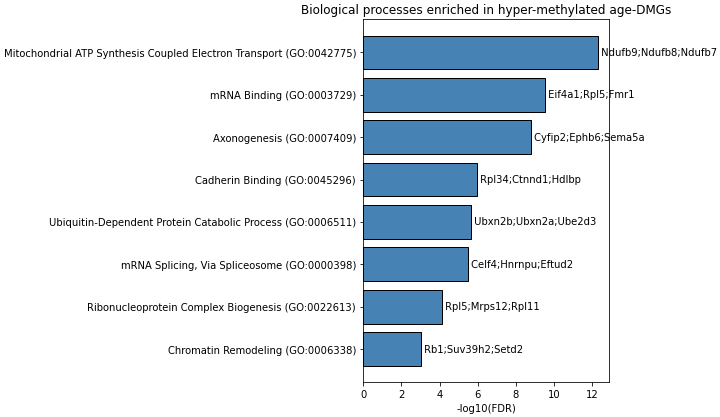

In [81]:
# Plot
plt.figure(figsize=(10, 6))
#plt.barh(for_bar_plot['Term'], for_bar_plot['-log10(FDR)'], color='steelblue', edgecolor='black')
# Annotate bars with the first 5 genes
bars = plt.barh(for_bar_plot['Term'], for_bar_plot['-log10(FDR)'], color='steelblue', edgecolor='black')

for i, (bar, genes) in enumerate(zip(bars, for_bar_plot['Genes'])):
    genes_list = genes.split(';')[:3]  # Get the first 5 genes
    annotation = ';'.join([format_gene(gene) for gene in genes_list])  # Format genes for the first bar
    
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {annotation}', va='center')

plt.xlabel('-log10(FDR)')
plt.xlabel('-log10(FDR)')
plt.title('Biological processes enriched in hyper-methylated age-DMGs')
plt.gca().invert_yaxis()  # Highest values at the top
plt.tight_layout()
plt.savefig(f'figure/{group}.barplot.pdf', dpi=300)
plt.show()
